# SUMMARY 

## approx 0 - 8 lice annotations per fish crop

## sorted lice category are
['ADULT_FEMALE', 'MOVING', 'SCOTTISH_ADULT_FEMALE', 'UNSURE']

In [10]:
from research.utils.data_access_utils import RDSAccessUtils, S3AccessUtils
import json
import os
import  pandas as pd
import matplotlib.patches as patches
from tqdm import tqdm

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
%matplotlib inline
from utils import utils, data_prep


In [63]:
import cv2
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed

In [64]:
import importlib
importlib.reload(utils)
importlib.reload(data_prep)

<module 'utils.data_prep' from '/root/jane/cv_research/jane/lice_counting/utils/data_prep.py'>

In [23]:
SEED = 33
CROP_WIDTH = 512
CROP_HEIGHT = 512

LICE_BBOX_EC = ['b', 'r', 'grey', 'yellow'] # bbox edge color
LICE_CATEGORY = ['ADULT_FEMALE', 'MOVING', 'SCOTTISH_ADULT_FEMALE', 'UNSURE']
#LABEL_PATH = 'data/moving_lice_crop_labels'
#IMAGE_PATH = 'data/moving_lice_crop_images'

# load annotation data

In [211]:
# docker-compose up 
#credentials = json.load(open(os.environ["DATA_WAREHOUSE_SQL_CREDENTIALS"]))

# docker run
credentials = json.load(open("/root/jane/cv_research/jane/deploy/data_warehouse_sql_credentials.json"))

rds_access_utils = RDSAccessUtils(credentials)

get_annotation_data = """
    SELECT 
        group_id,
        left_crop_url,
        annotation 
    FROM 
        prod.crop_annotation 
    WHERE 
        (captured_at BETWEEN '2019-10-01' AND '2019-12-01') AND 
        (group_id = '56') AND
        (annotation_state_id IN (7)) AND
        (service_id = 1);
"""
annotation_data = rds_access_utils.extract_from_database(get_annotation_data)

In [212]:
annotation_data.head(3)

,group_id,left_crop_url,annotation
0,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:13:42.783757000Z/left_frame_crop_846_600_3122_1385.jpg,None
1,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/left_frame_crop_1286_524_3434_1555.jpg,"[{'id': '37c09621-e422-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 177, 'left': 571, 'width': 23, 'height': 11}}, {'id': '37c09622-e422-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 178, 'left': 543, 'width': 26, 'height': 12}}]"
2,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:15:12.635108000Z/left_frame_crop_958_178_3274_1374.jpg,None


In [58]:
annotation_data.iloc[1]['annotation']

[{'id': '37c09621-e422-11e9-a674-ad85428a0e40',
  'category': 'MOVING',
  'location': 'TOP',
  'position': {'top': 177, 'left': 571, 'width': 23, 'height': 11}},
 {'id': '37c09622-e422-11e9-a674-ad85428a0e40',
  'category': 'MOVING',
  'location': 'TOP',
  'position': {'top': 178, 'left': 543, 'width': 26, 'height': 12}}]

# Histogram of lice count in each fish crop

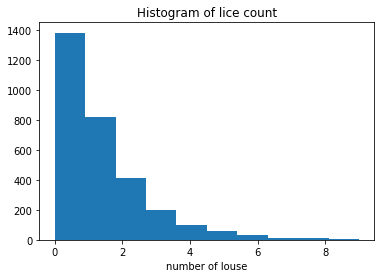

In [8]:
lice_count = []
for _, sf in annotation_data.iterrows():
    if sf['annotation']:
        lice_count.append(len(sf['annotation']))
    else:
        lice_count.append(0)
        
_ = plt.hist(lice_count)  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=20)
plt.title("Histogram of lice count")
plt.xlabel('number of louse')
plt.show()

# bar chart of lice by category, location or both

In [178]:
count = {}
for _, sf in annotation_data.iterrows():
    if sf['annotation']:
        for louse in sf['annotation']:
            if louse["category"] not in ('ADULT_FEMALE', 'MOVING') or not louse["location"]:
                continue
            key = str((louse["category"][0], louse["location"][0]))
            #key = louse["location"]
            if count.get(key):
                count[key] += 1
            else:
                count[key] = 1

In [179]:
keys = list(count.keys())
keys.sort()
counts = [count[key] for key in keys]

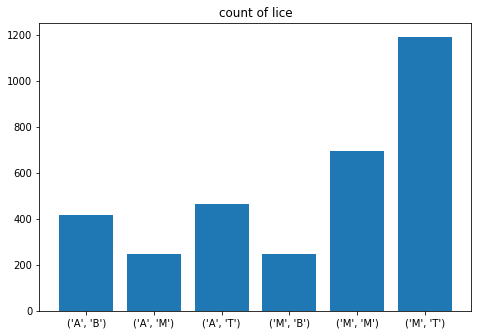

In [180]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys, counts)
plt.title("count of lice")
plt.show()

# bbox dimension plot

In [206]:
df = pd.DataFrame()
for _, sf in annotation_data.iterrows():
    if sf['annotation']:
        for lice in sf['annotation']:
            if lice['category'] not in ['ADULT_FEMALE', 'MOVING']:
                continue
            df = df.append({"category": lice['category'], 
                            'location': lice['location'],
                            "width": lice['position']['width'], 
                            "height": lice['position']['height']}, ignore_index=True)   

In [203]:
df.head(3)

,category,height,location,width
0,MOVING,11.0,TOP,23.0
1,MOVING,12.0,TOP,26.0
2,MOVING,19.0,TOP,22.0


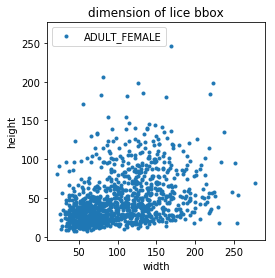

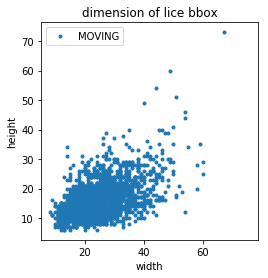

In [220]:
categories = df.groupby('category')

for name, group in categories:

    plt.plot(group.width, group.height, marker=".", linestyle="", label=name)

    plt.legend()
    plt.axis('square')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title("dimension of lice bbox")
    plt.show()

# fish crop with lice bbox

In [21]:
# s3_access_utils = S3AccessUtils('/root/data')

import boto3
from urllib.parse import urlparse


aws_credentials = json.load(open('/root/jane/cv_research/jane/deploy/aws_credentials.json'))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
aws_secret_access_key=aws_credentials["aws_secret_access_key"],
            region_name="eu-west-1")

def recursive_mkdir(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    return
    
def download_from_s3(bucket, key, custom_location=None):
    if custom_location:
        recursive_mkdir(os.path.dirname(custom_location))
        s3_client.download_file(bucket, key, custom_location)
    else:
        s3_base_dir = os.path.join('/root/data', 's3')
        f = os.path.join(s3_base_dir, bucket, key)
        if not os.path.exists(f):
            recursive_mkdir(os.path.dirname(f))
            s3_client.download_file(bucket, key, f)
        return f
    
def download_from_url(url):
    parsed_url = urlparse(url, allow_fragments=False)
    if parsed_url.netloc.startswith('s3'):
        url_components = parsed_url.path.lstrip('/').split('/')
        bucket, key = url_components[0], os.path.join(*url_components[1:])
    else:
        bucket = parsed_url.netloc.split('.')[0]
        key = parsed_url.path.lstrip('/')
    image_f = download_from_s3(bucket, key)
    return image_f, bucket, key

In [20]:
# low-res
#fig, ax = plt.subplots(figsize=(12, 12)) 
#image = plt.imread(image_f)
#img = Image.open(image_f)
#img = img.resize((200,200)).resize((image.shape[1], image.shape[0]))

In [ ]:
# for confluence  documentation 
num_pic = -1
nrows = 5
figure, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(20, nrows * 6))

for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation']:
        continue
    num_pic += 1
    if num_pic >= nrows * 2:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    image = plt.imread(image_f)
    
    img = Image.open(image_f)

    #img = img.resize((512,512)).resize((image.shape[1], image.shape[0]))


    alpha = 3 # Contrast control (1.0-3.0)
    beta = 20 # Brightness control (0-100)

    img = np.asarray(img)
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    axes[num_pic // 2, num_pic % 2].imshow(adjusted)
    axes[num_pic // 2, num_pic % 2].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    axes[num_pic // 2, num_pic % 2].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.axis('off')
    
    axes[num_pic // 2, num_pic % 2].get_xaxis().set_visible(False)
    axes[num_pic // 2, num_pic % 2].get_yaxis().set_visible(False)
    
    for lice in sf['annotation']:
        lp = lice['position'] # only take the first female adult
        x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
        class_index = LICE_CATEGORY.index(lice['category'])
        ec = LICE_BBOX_EC[class_index]
        rect = patches.Rectangle((x, y), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
        axes[num_pic // 2, num_pic % 2].add_patch(rect)

figure.tight_layout()

# lice crop

## visualize random lice crop

In [ ]:
# # for confluence  documentation 
# seed(SEED)
# num_pic = -1
# figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# for idx, sf in tqdm(annotation_data.iterrows()):
#     if not sf['annotation']:
#         continue
#     num_pic += 1
#     if num_pic > 3:
#         break
#     left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
#     image_f = left_image_f 

#     iw = sf['left_crop_metadata']['width']
#     ih = sf['left_crop_metadata']['height']
#     print(sf['annotation'])
#     crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT])

#     print("num of crops {}".format(len(crops)))
#     for crop in crops:
        
#         image = plt.imread(image_f)
        
#         # crop lice image
#         crop_left, crop_top = crop
#         print("crop {} {}".format(crop_left, crop_top))
#         cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
#         # adjust image contrast and brightness
#         alpha = 3 # Contrast control (1.0-3.0)
#         beta = 20 # Brightness control (0-100)
#         adjusted = cv2.convertScaleAbs(cropped_image, alpha=alpha, beta=beta)
        
#         axes[num_pic // 2, num_pic % 2].imshow(adjusted)

    
#         for lice in crops[crop]:
#             lp = lice['position'] # only take the first female adult
#             x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            
#             class_index = LICE_CATEGORY.index(lice['category'])
#             ec = LICE_BBOX_EC[class_index]
#             crop_left_offset = x - crop_left
#             crop_top_offset = y - crop_top
#             rect = patches.Rectangle((crop_left_offset, crop_top_offset), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
#             axes[num_pic // 2, num_pic % 2].add_patch(rect)    

# figure.tight_layout()


In [ ]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation'] or idx < 10:
        continue
    if idx > 20:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    print(sf['annotation'])
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT])

    print("num of crops {}".format(len(crops)))
    for crop in crops:
        
        fig, ax = plt.subplots(figsize=(10, 10))
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        print("crop {} {}".format(crop_left, crop_top))
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        # adjust image contrast and brightness
        alpha = 3 # Contrast control (1.0-3.0)
        beta = 20 # Brightness control (0-100)
        adjusted = cv2.convertScaleAbs(cropped_image, alpha=alpha, beta=beta)
        
        ax.imshow(adjusted)

    
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            
            class_index = LICE_CATEGORY.index(lice['category'])
            ec = LICE_BBOX_EC[class_index]
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top
            rect = patches.Rectangle((crop_left_offset, crop_top_offset), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
            ax.add_patch(rect)    

        plt.show()

## generate and write data for model

In [ ]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation']:
        continue

    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    
    # randomly generate crops around lice
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT ])

    print("num of crops {}, out of {} lice".format(len(crops), len(sf['annotation'])))
    i = -1
    for crop in crops:
        i += 1
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        # get file name
        start, end = "left_frame_crop_", ".jpg"
        s = sf["left_crop_url"]
        file_name = "left_" + s[s.find(start)+ len(start):s.find(end)]
        file_name += "_CROP_{}_{}".format(i, len(crops))    
        
        # save image
        data_prep.write_image(cropped_image, file_name, IMAGE_PATH)
        
        labels = []
        
        # save labels
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            class_index = LICE_CATEGORY.index(lice['category'])
            
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top            
            
            xywh = [crop_left_offset, crop_top_offset, w, h]
            bbox = utils.xywh2yolobbox(xywh, [CROP_WIDTH, CROP_HEIGHT])
            
            labels.append([class_index] + bbox)

            
        data_prep.write_labels(labels, file_name, LABEL_PATH)


## ONLY MOVING LICE

In [ ]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation']:
        continue
    if idx > 200:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    
    # randomly generate crops around lice
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT], ['MOVING'])

    print("num of crops {}, out of {} lice".format(len(crops), len(sf['annotation'])))
    i = -1
    for crop in crops:
        i += 1
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        # print("crop {} {}".format(crop_left, crop_top))
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        # get file name
        start, end = "left_frame_crop_", ".jpg"
        s = sf["left_crop_url"]
        file_name = "left_" + s[s.find(start)+ len(start):s.find(end)]
        file_name += "_CROP_{}_{}".format(i, len(crops))    
        
        # save image
        data_prep.write_image(cropped_image, file_name, IMAGE_PATH)
        
        labels = []
        
        # save labels
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            print(lice['category'])
            class_index = 0
            
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top            
            
            xywh = [crop_left_offset, crop_top_offset, w, h]
            bbox = utils.xywh2yolobbox(xywh, [CROP_WIDTH, CROP_HEIGHT])
            
            labels.append([class_index] + bbox)

            
        data_prep.write_labels(labels, file_name, LABEL_PATH)
